## Imports

In [1]:
import ast
import time
import pickle
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Global variables

In [2]:
scaler = MinMaxScaler()

# One hot encoding
genres_mlb = MultiLabelBinarizer()
spoken_languages_mlb = MultiLabelBinarizer()
production_countries_mlb = MultiLabelBinarizer()

# Label encoding
original_language_encoder = LabelEncoder()
status_encoder = LabelEncoder()
name_encoder = LabelEncoder()
character_encoder = LabelEncoder()

# Hashing encoding
keywords_hash_num = 30    #Change this Number for more accuracy
keywords_hash_columns = []
hash_column_name = ''

for i in range(keywords_hash_num):
  hash_column_name = 'keywords_hash_' + str(i)
  keywords_hash_columns.append(hash_column_name)

keywords_hasher = FeatureHasher(n_features=keywords_hash_num, input_type='string')


production_companies_hash_num = 20 #Change this Number for more accuracy
production_companies_hash_columns = []
hash_column_name = ''

for i in range(production_companies_hash_num):
  hash_column_name = 'production_companies_hash_' + str(i)
  production_companies_hash_columns.append(hash_column_name)

production_companies_hasher = FeatureHasher(n_features=production_companies_hash_num, input_type='string')


tfidf  = TfidfVectorizer(stop_words='english')


cast_num = 1  
cast_columns = []
cast_character = ''
cast_gender = ''
cast_name = ''
cast_order = ''

for i in range(cast_num):
  cast_character = 'cast_' + str(i) + '_character'
  cast_gender = 'cast_' + str(i) + '_gender'
  cast_name = 'cast_' + str(i) + '_name'
  cast_order = 'cast_' + str(i) + '_order'

  cast_columns.append(cast_character)
  cast_columns.append(cast_gender)
  cast_columns.append(cast_name)
  cast_columns.append(cast_order)

rate_encoder = LabelEncoder()


missingValues = {
    'budget'  :  None,
    'genres'  :  None,
    'homepage'  :  None,
    'id'  :  None,
    'keywords'  :  None,
    'original_language'  :  None,
    'original_title'  :  None,
    'overview'  :  None,
    'viewercount'  :  None,
    'production_companies'  :  None,
    'production_countries'  :  None,
    'release_date'  :  None,
    'revenue'  :  None,
    'runtime'  :  None,
    'spoken_languages'  :  None,
    'status'  :  None,
    'tagline'  :  None,
    'title'  :  None,
    'vote_count'  :  None,
    'cast'  :  None,
    'crew'  :  None,
}


## Helper functions

### Save the models

In [3]:

# Save the encoding objects
def save_encoders(encoding):
    with open('encoders.pkl', 'wb') as file:
        pickle.dump(encoding, file)

# Save the feature hashers
def save_hashers(hash):
    with open('hashers.pkl', 'wb') as file:
        pickle.dump(hash, file)

# Save the TF-IDF vectorizer
def save_tfidf_vectorizer(tf_idf):
    with open('tfidf_vectorizer.pkl', 'wb') as file:
        pickle.dump(tf_idf, file)

# Save the scalers
def save_scalers(scale):
    with open('scalers.pkl', 'wb') as file:
        pickle.dump(scale, file)

# Save the feature selection
def save_feature_selection(feature):
    with open('feature_selection.pkl', 'wb') as file:
        pickle.dump(feature, file)

# Save the model
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)


  
# Save the missing values
def save_missing_values(missingValues):
    with open('missing_values.pkl', 'wb') as file:
        pickle.dump(missingValues, file)
     



### Load the models

In [4]:

# Load the encoding objects
def load_encoders():
    with open('encoders.pkl', 'rb') as file:
        encodings = pickle.load(file)

        
    genres_mlb = encodings['genres_mlb']
    spoken_languages_mlb = encodings['spoken_languages_mlb']
    production_countries_mlb = encodings['production_countries_mlb']
    original_language_encoder = encodings['original_language_encoder']
    status_encoder = encodings['status_encoder']
    name_encoder = encodings['name_encoder']
    character_encoder = encodings['character_encoder']
    rate_encoder = encodings['rate_encoder']
    
    return genres_mlb, spoken_languages_mlb, production_countries_mlb, original_language_encoder, status_encoder, name_encoder, character_encoder, rate_encoder

# Load the feature hashers
def load_hashers():
    with open('hashers.pkl', 'rb') as file:
        hashing = pickle.load(file)

    keywords_hasher = hashing['keywords_hasher']
    production_companies_hasher = hashing['production_companies_hasher']

    return keywords_hasher, production_companies_hasher
    

# Load the TF-IDF vectorizer
def load_tfidf_vectorizer():
    with open('tfidf_vectorizer.pkl', 'rb') as file:
        return pickle.load(file)


# Load the scalers
def load_scalers():
    with open('scalers.pkl', 'rb') as file:
        return pickle.load(file)

# Load the feature selection
def load_feature_selection():
    with open('feature_selection.pkl', 'rb') as file:
        return pickle.load(file)

# Load the models
def load_model(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)
    
# Load the missing values
def load_missing_values():
    with open('missing_values.pkl', 'rb') as file:
        return pickle.load(file)



### Adding a new label in label encoding

In [5]:
def unseen(data, encoder, columnName):
    unseen_values = list(set(data[columnName]) - set(encoder.classes_))
    if unseen_values:
        for unseen in unseen_values:
            if unseen not in encoder.classes_:
                new_label = max(encoder.transform(encoder.classes_)) + 1
                encoder.classes_ = np.append(encoder.classes_, unseen)
                encoder.transform([unseen])[0] = new_label



### Converting list of dictionaries to normal list of elements


In [6]:
def transformColumn(enteredData, columnName, dictionaryKey):
    enteredData[columnName] = [ast.literal_eval(row) for row in enteredData[columnName]]
    for index, row in enteredData[columnName].items():
        finalList = []
        for j in range(len(row)):
            finalList.append(row[j][dictionaryKey])
        enteredData.at[index, columnName] = finalList


In [7]:
def transformMoviesColumns(enteredData, columnName, dictionaryKey1, dictionaryKey2, dictionaryKey3, dictionaryKey4):
  enteredData[columnName] = [ast.literal_eval(row) for row in enteredData[columnName]]
  for index, row in enteredData[columnName].items():
    finalList = []
    for j in range(len(row)):
      fList = []
      fList.append(row[j][dictionaryKey1])
      fList.append(row[j][dictionaryKey2])
      fList.append(row[j][dictionaryKey3])
      fList.append(row[j][dictionaryKey4])
      finalList.append(fList)
    enteredData.at[index, columnName] = finalList


### Filling missing values

#### Filling missing values in numerical columns with mean value


In [8]:
def fillNumericalData(enteredData, columnName):
  mean_val = np.mean(enteredData[enteredData[columnName] != 0][columnName])
  enteredData[columnName] = enteredData[columnName].replace(0, mean_val)
  missingValues[columnName] = mean_val
  enteredData[columnName] =  enteredData[columnName].fillna(mean_val)


#### Filling missing values in categoral columns with mod category 


In [9]:
def fillCategoralData(enteredData, columnName):
    list_counter = Counter(tuple(lst) for lst in enteredData[columnName])
    mode_list = list(max(list_counter, key=list_counter.get))
    if not mode_list:
        mode_list = list(sorted(list_counter, key=list_counter.get, reverse=True)[1])
    enteredData[columnName] = enteredData[columnName].apply(lambda x: x if x else mode_list)
    missingValues[columnName] = mode_list



In [10]:
def fillMoviesCategoralData(enteredData, columnName):
    tuple_counter = Counter(tuple(inner_lst) for lst in enteredData[columnName] for inner_lst in lst)
    mode_tuple = max(tuple_counter, key=tuple_counter.get)
    mode_list = [list(mode_tuple)]
    if not mode_list:
        mode_list = [list(sorted(tuple_counter, key=tuple_counter.get, reverse=True)[1])]
    enteredData[columnName] = enteredData[columnName].apply(lambda lst: lst if lst else mode_list)
    missingValues[columnName] = mode_list



### Preprocessing to the non-models 

In [11]:

def nonModels_preprocessing(data):
    # converting list of dectionaries to normal lists of elements using "transformColumn" function
    # genres column
    transformColumn(data, 'genres', 'name')
    # keywords column
    transformColumn(data, 'keywords', 'name')
    # production_companies column
    transformColumn(data, 'production_companies', 'name')
    # production_countries column
    transformColumn(data, 'production_countries', 'name')
    # spoken_languages column
    transformColumn(data, 'spoken_languages', 'iso_639_1')
    # cast column
    transformMoviesColumns(data, 'cast', 'character', 'gender', 'name', 'order')
    # crew column
    transformMoviesColumns(data, 'crew', 'name', 'department', 'gender', 'job')

    # Only leaving the year from the release date column
    data['release_date'] = data['release_date'].str[-4:].astype(int)
    
    # fill missing values of categoral data with mod category using "fillCategoralData" function
    # genres column
    fillCategoralData(data, 'genres')
    # keywords column
    fillCategoralData(data, 'keywords')
    # spoken_languages column
    fillCategoralData(data, 'spoken_languages')
    # production_companies column
    fillCategoralData(data, 'production_companies')
    # production_countries column
    fillCategoralData(data, 'production_countries')
    # cast column
    fillMoviesCategoralData(data, 'cast')
    # crew column
    fillMoviesCategoralData(data, 'crew')

    # fill missing values in numerical columns with mean value in column 
    # budget column
    fillNumericalData(data, 'budget')
    # id column
    fillNumericalData(data, 'id')
    # viewercount column
    fillNumericalData(data, 'viewercount')
    # release_date column
    fillNumericalData(data, 'release_date')
    # revenue column
    fillNumericalData(data, 'revenue')
    # runtime column
    fillNumericalData(data, 'runtime')
    # vote_count column
    fillNumericalData(data, 'vote_count')
   

    # fill missing values in textual columns with mod value in column
    # homepage column
    missingValues['homepage'] = (data['homepage'].mode()[0])
    data['homepage'] = data['homepage'].fillna(data['homepage'].mode()[0])
    
    # tagline column
    missingValues['tagline'] = (data['tagline'].mode()[0])
    data['tagline'] = data['tagline'].fillna(data['tagline'].mode()[0])
    
    # overview column
    missingValues['overview'] = (data['overview'].mode()[0])
    data['overview'] = data['overview'].fillna(data['overview'].mode()[0])
    
    # original_language column
    missingValues['original_language'] = (data['original_language'].mode()[0])
    data['original_language'] =  data['original_language'].fillna(data['original_language'].mode()[0])
    
    # original_title column
    missingValues['original_title'] = (data['original_title'].mode()[0])
    data['original_title'] =  data['original_title'].fillna(data['original_title'].mode()[0])
    
    # status column
    missingValues['status'] = (data['status'].mode()[0])
    data['status'] =  data['status'].fillna(data['status'].mode()[0])
    
    # status column
    missingValues['title'] = (data['title'].mode()[0])
    data['title'] =  data['title'].fillna(data['title'].mode()[0])



    # Placing the values from the cast column to a column of it's own  
    data = data.join(pd.DataFrame(columns=cast_columns, index = data.index))
    for index, row in data.iterrows():
      k = 0
      for j in range(cast_num):
        if(j > len(row['cast']) - 1):
          break 
        data.at[index, cast_columns[k]] = row['cast'][j][0]
        k += 1
        data.at[index, cast_columns[k]] = row['cast'][j][1]
        k += 1
        data.at[index, cast_columns[k]] = row['cast'][j][2]
        k += 1
        data.at[index, cast_columns[k]] = row['cast'][j][3]
        k += 1

    data.drop('cast',axis=1,inplace=True)
    
    return data


In [12]:

def fillMissingTestData(data):
    missingValues = load_missing_values()
    
    categoralColumns = ['genres', 'keywords', 'spoken_languages',
                        'production_companies', 'production_countries', 'cast', 'crew']
    for i in categoralColumns:
        data[i] = data[i].apply(lambda x: x if x else missingValues[i])
   
    numericalColumns = ['budget', 'id', 'viewercount',
                    'release_date', 'revenue', 'runtime', 'vote_count']
    for i in numericalColumns:
        data[i] = data[i].replace(0, missingValues[i])
        data[i] =  data[i].fillna(missingValues[i])

    textualColumns = ['homepage', 'original_title', 'tagline',
                      'title', 'status', 'overview', 'original_language']
    for i in textualColumns:
        data[i] =  data[i].fillna(missingValues[i])

    return data
    


In [13]:

def nonModels_preprocessing_script(data):
    # converting list of dectionaries to normal lists of elements using "transformColumn" function
    # genres column
    transformColumn(data, 'genres', 'name')
    # keywords column
    transformColumn(data, 'keywords', 'name')
    # production_companies column
    transformColumn(data, 'production_companies', 'name')
    # production_countries column
    transformColumn(data, 'production_countries', 'name')
    # spoken_languages column
    transformColumn(data, 'spoken_languages', 'iso_639_1')
    # cast column
    transformMoviesColumns(data, 'cast', 'character', 'gender', 'name', 'order')
    # crew column
    transformMoviesColumns(data, 'crew', 'name', 'department', 'gender', 'job')

    # Only leaving the year from the release date column
    data['release_date'] = data['release_date'].str[-4:].astype(int)

    data = fillMissingTestData(data)

    # Placing the values from the cast column to a column of it's own  
    data = data.join(pd.DataFrame(columns=cast_columns, index = data.index))
    for index, row in data.iterrows():
      k = 0
      for j in range(cast_num):
        if(j > len(row['cast']) - 1):
          break 
        data.at[index, cast_columns[k]] = row['cast'][j][0]
        k += 1
        data.at[index, cast_columns[k]] = row['cast'][j][1]
        k += 1
        data.at[index, cast_columns[k]] = row['cast'][j][2]
        k += 1
        data.at[index, cast_columns[k]] = row['cast'][j][3]
        k += 1

    data.drop('cast',axis=1,inplace=True)
    
    
    return data


## Load data

In [14]:
data = pd.read_csv('movies-classification-dataset.csv')
X = data.iloc[:, :19] 
Y = data['Rate']
movies = pd.read_csv('movies-credit-students-train.csv')


## Add the cast and crew columns to X dataFrame

In [15]:
def join_columns(data, movies):
  # Add two empty columns to the DataFrame
  data = data.join(pd.DataFrame(movies['cast'], columns=['cast'], index = data.index))
  data = data.join(pd.DataFrame(movies['crew'], columns=['crew'], index = data.index))

  # Put the cast and crew in the right cells
  for dataIndex, dataRow in data.iterrows():
    if dataRow['id'] in movies['movie_id'].values:
      index = movies.loc[movies['movie_id'] == dataRow['id']].index[0]
      data.at[dataIndex, 'cast'] = movies.at[index, 'cast']
      data.at[dataIndex, 'crew'] = movies.at[index, 'crew']
    else:
      data.at[dataIndex, 'cast'] = '[]'
      data.at[dataIndex, 'crew'] = '[]'
  
  return data


## Distribution of the vote_average rating


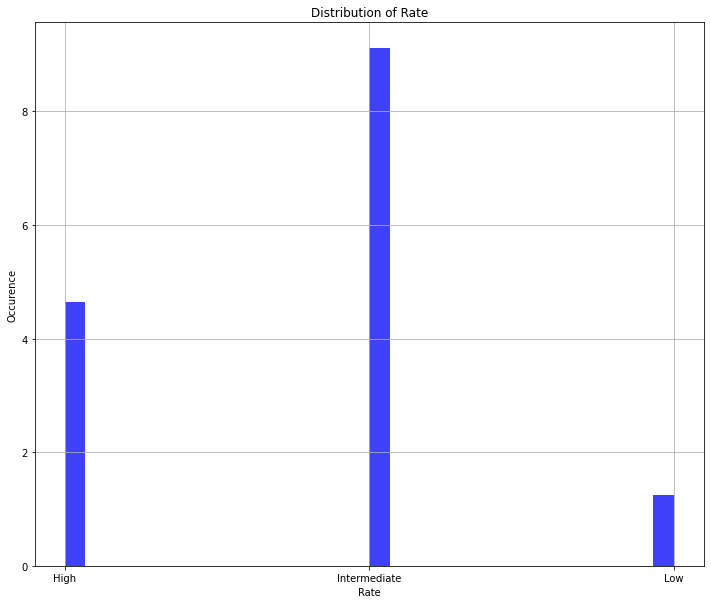

In [16]:
plt.subplots(figsize=(12,10))
n, bins, patches = plt.hist(Y, 30, density=1, facecolor='b', alpha=0.75)

plt.xlabel('Rate')
plt.ylabel('Occurence')
plt.title('Distribution of Rate')
plt.grid(True)
plt.show()

## Split Data

In [17]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

# test_data =  pd.DataFrame(X_Test, columns=X.columns) 
# test_data['Rate'] = Y_Test

# test_data.to_csv('test.csv', index=False)


In [18]:
# import pandas as pd
# import numpy as np

# def count_outliers(df):
#     # Calculate z-scores for each column
#     z_scores = np.abs((df - df.mean()) / df.std())

#     # Set a threshold for outlier detection (e.g., z-score > 3)
#     threshold = 3

#     # Count the number of outliers in each column
#     num_outliers = (z_scores > threshold).sum()

#     return num_outliers

# # Example usage
# # Assuming 'df' is your dataframe
# outliers_count = count_outliers(data)
# print("Number of outliers in the dataframe:", outliers_count)


## Preprocessing test Script

In [19]:

# Apply the loaded encodings to the test data
def apply_encodings(data, y):
    # Load the encoding objects, hashers, vectorizer, and scalers
    genres_mlb, spoken_languages_mlb, production_countries_mlb, original_language_encoder, status_encoder, name_encoder, character_encoder, rate_encoder =  load_encoders()
    keywords_hasher, production_companies_hasher =  load_hashers()
    tfidf = load_tfidf_vectorizer()
    scaler = load_scalers()
    
    # Apply one-hot encoding
    # genres column
    data = data.join(pd.DataFrame(genres_mlb.transform(data.pop('genres')),
                                    columns=genres_mlb.classes_,
                                    index=data.index))
    
    # spoken_languages column
    data = data.join(pd.DataFrame(spoken_languages_mlb.transform(data.pop('spoken_languages')),
                                    columns=spoken_languages_mlb.classes_,
                                    index=data.index))
    # production_countries column 
    data = data.join(pd.DataFrame(production_countries_mlb.transform(data.pop('production_countries')),
                                    columns=production_countries_mlb.classes_,
                                    index=data.index))
    

    # Apply lable encoding
    # original_language column
    unseen(data, original_language_encoder, 'original_language')
    data['original_language'] = original_language_encoder.transform(data['original_language'])
    # status column
    unseen(data, status_encoder, 'status')
    data['status'] = status_encoder.transform(data['status'])
    # cast column
    for i in range(cast_num):
        cast_name = 'cast_' + str(i) + '_name'
        
        unseen(data, name_encoder, cast_name)
        data[cast_name] = name_encoder.transform(data[cast_name])


        cast_character = 'cast_' + str(i) + '_character'

        unseen(data, character_encoder, cast_character)
        data[cast_character] = character_encoder.transform(data[cast_character])
            
    # Apply hashing encoding
    # keywords column
    data = data.join(pd.DataFrame((keywords_hasher.transform(data.pop('keywords')).toarray()), columns=keywords_hash_columns, index=data.index))
    # production_companies column
    data = data.join(pd.DataFrame((production_companies_hasher.transform(data.pop('production_companies')).toarray()), columns=production_companies_hash_columns, index=data.index))


    # Apply TF-IDF 
    overview_vectors  = tfidf.transform(data['overview'])        
    data['overview'] = list(overview_vectors.toarray())
    data['overview'] = data['overview'].apply(lambda x: sum(x) / len(x))


    # Normalizing the numerical columns
    num_cols = data.select_dtypes(include=['int', 'float']).columns.tolist()
    data[num_cols] = scaler.transform(data[num_cols])


        
    data.drop('homepage',axis=1,inplace=True)
    data.drop('id',axis=1,inplace=True)
    data.drop('original_title',axis=1,inplace=True)
    data.drop('tagline',axis=1,inplace=True)
    data.drop('title',axis=1,inplace=True)
    data.drop('crew',axis=1,inplace=True)

    y = rate_encoder.transform(y)

    return data, y



## Preprocessing

In [20]:

def Preprocessing(data, y, movie):
    data = join_columns(data, movie)

    data = nonModels_preprocessing(data)

    # Applying one hot encoding on three categoral columns (genres, spoken_languages, production_countries) 
    # genres column
    data = data.join(pd.DataFrame(genres_mlb.fit_transform(data.pop('genres')), columns=genres_mlb.classes_, index=data.index))
    
    # spoken_languages column
    data = data.join(pd.DataFrame(spoken_languages_mlb.fit_transform(data.pop('spoken_languages')), columns=spoken_languages_mlb.classes_, index=data.index))
    
    # production_countries column
    data = data.join(pd.DataFrame(production_countries_mlb.fit_transform(data.pop('production_countries')), columns=production_countries_mlb.classes_, index=data.index))



    # Applying lable encoding on column (original_language, status, cast)
    # original_language column
    original_language_encoder.fit(data['original_language'])
    data['original_language'] = original_language_encoder.transform(data['original_language'])
    
    # status column
    status_encoder.fit(data['status'])
    data['status'] = status_encoder.transform(data['status'])

    # cast column
   
    for i in range(cast_num):
      cast_name = 'cast_' + str(i) + '_name'
      cast_character = 'cast_' + str(i) + '_character'

      name_encoder.fit(data[cast_name])
      character_encoder.fit(data[cast_character])

      data[cast_name] = name_encoder.transform(data[cast_name])
      data[cast_character] = character_encoder.transform(data[cast_character])
     

    # Applying hashing encoding on two catigoral columns ('keywords', 'production_companies')
    # keywords column
    data = data.join(pd.DataFrame((keywords_hasher.fit_transform(data.pop('keywords')).toarray()), columns=keywords_hash_columns, index=data.index))
    # production_companies column
    data = data.join(pd.DataFrame((production_companies_hasher.fit_transform(data.pop('production_companies')).toarray()), columns=production_companies_hash_columns, index=data.index))
    
    # Applying TF-IDF on the overview column
    overview_vectors  = tfidf.fit_transform(data['overview'])        
    data['overview'] = list(overview_vectors.toarray())
    data['overview'] = data['overview'].apply(lambda x: sum(x) / len(x))
    

    num_cols = data.select_dtypes(include=['int', 'float']).columns.tolist()
    # Normalizing the numerical columns
    data[num_cols] = scaler.fit_transform(data[num_cols])
    
        
    data.drop('homepage',axis=1,inplace=True)
    data.drop('id',axis=1,inplace=True)
    data.drop('original_title',axis=1,inplace=True)
    data.drop('tagline',axis=1,inplace=True)
    data.drop('title',axis=1,inplace=True)
    data.drop('crew',axis=1,inplace=True)
   
    # Rate column
    rate_encoder.fit(y)
    y = rate_encoder.transform(y)

    return data, y


X_Train, Y_Train = Preprocessing(X_Train, Y_Train, movies)

encoders = {
        'genres_mlb': genres_mlb,
        'spoken_languages_mlb': spoken_languages_mlb,
        'production_countries_mlb': production_countries_mlb,
        'original_language_encoder': original_language_encoder,
        'status_encoder': status_encoder,
        'name_encoder': name_encoder,
        'character_encoder': character_encoder,
        'rate_encoder': rate_encoder
    }

hashers = {
        'keywords_hasher': keywords_hasher,
        'production_companies_hasher': production_companies_hasher
    }

# Save the encoding objects, hashers, vectorizer, and scalers
save_encoders(encoders)
save_hashers(hashers)
save_tfidf_vectorizer(tfidf)
save_scalers(scaler)
save_missing_values(missingValues)

X_Test = join_columns(X_Test, movies)
X_Test = nonModels_preprocessing_script(X_Test)
X_Test, Y_Test = apply_encodings(X_Test, Y_Test)

 

c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\preprocessing\_label.py:861: UserWarning: unknown class(es) ['am', 'bs', 'ca', 'ce', 'co', 'km', 'mi', 'sa', 'si'] will be ignored
  .format(sorted(unknown, key=str)))
c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\preprocessing\_label.py:861: UserWarning: unknown class(es) ['Aruba', 'Libyan Arab Jamahiriya', 'Serbia'] will be ignored
  .format(sorted(unknown, key=str)))


In [21]:
print(X_Train.head())

        budget  original_language  overview  viewercount  release_date  \
2925  0.064286                0.2  0.771909     0.017035      0.786517   
507   0.267857                0.2  0.521937     0.017294      0.797753   
924   0.160714                0.2  0.581516     0.007138      0.775281   
2116  0.149667                0.2  0.246699     0.003169      0.853933   
1363  0.250000                0.2  0.439711     0.027023      0.921348   

       revenue   runtime  status  vote_count  cast_0_character  ...  \
2925  0.002883  0.239057     1.0    0.012726          0.085409  ...   
507   0.016745  0.212121     1.0    0.024507          0.840302  ...   
924   0.044309  0.171717     1.0    0.007199          0.599644  ...   
2116  0.044309  0.225589     1.0    0.002182          0.106317  ...   
1363  0.037642  0.168350     1.0    0.040361          0.136121  ...   

     production_companies_hash_10  production_companies_hash_11  \
2925                          0.6                          0.

In [22]:
print(X_Test.head())

        budget  original_language  overview  viewercount  release_date  \
1014  0.014286                0.2  0.247068     0.027595      0.988764   
794   0.028571                0.2  0.391920     0.002454      0.775281   
1414  0.053571                0.2  0.481381     0.007832      0.820225   
1790  0.296429                0.2  0.258986     0.007136      0.820225   
263   0.033929                0.2  0.493600     0.016109      0.966292   

       revenue   runtime  status  vote_count  cast_0_character  ...  \
1014  0.018804  0.168350     1.0    0.074249          1.140569  ...   
794   0.044309  0.188552     1.0    0.002109          1.037811  ...   
1414  0.012113  0.265993     1.0    0.011199          1.141459  ...   
1790  0.021330  0.164983     1.0    0.009672          1.218861  ...   
263   0.002798  0.158249     1.0    0.024216          1.206406  ...   

     production_companies_hash_10  production_companies_hash_11  \
1014                          0.4                          0.

## Feature selection

In [23]:
model = LogisticRegression(max_iter=5000)
# Recursive Feature Elemination
rfe = RFE(model, n_features_to_select=30)

rfe.fit(X_Train, Y_Train)

X_Train = rfe.transform(X_Train)

save_feature_selection(rfe)

X_Test = rfe.transform(X_Test)

## Models

### Decision Tree Classifier

In [24]:

dt_total_train_time = 0
dt_total_test_time = 0

# Decision Tree Classifier without any change of hyperparameters
dt = DecisionTreeClassifier(random_state=42)

dt_train_start_time = time.time()
dt.fit(X_Train, Y_Train)
dt_train_time = time.time() - dt_train_start_time
dt_total_train_time += dt_train_time

dt_test_start_time = time.time()
y_pred = dt.predict(X_Test)
dt_test_time = time.time() - dt_test_start_time
dt_total_test_time += dt_test_time

dt_accuracy = accuracy_score(Y_Test, y_pred)

print(f"Decision Tree Classifier without any change of hyperparameters: {dt_accuracy:.2f}\n")


# Define a list of hyperparameters to test
max_depths =  [2, 5, 7, 10]  
min_samples_splits = [10, 15, 37, 28]  

dt = DecisionTreeClassifier(random_state=42)

dt_max_accuracy = 0
samples = 0
dep = 0

print("Decision Tree Classifier accuracy with changing of hyperparameters")

# Train and evaluate the model for each hyperparameter combination
for depth in max_depths:
    for samples_split in min_samples_splits:

        dt = dt.set_params(max_depth=depth, min_samples_split=samples_split)
            
                
        dt_train_start_time = time.time()
        dt.fit(X_Train, Y_Train)
        dt_train_time = time.time() - dt_train_start_time
        dt_total_train_time += dt_train_time


        dt_test_start_time = time.time()
        y_pred = dt.predict(X_Test)
        dt_test_time = time.time() - dt_test_start_time
        dt_total_test_time += dt_test_time

        dt_accuracy = accuracy_score(Y_Test, y_pred)

        if(dt_accuracy > dt_max_accuracy):
            dt_max_accuracy = dt_accuracy
            samples = samples_split
            dep = depth 
            
        print(f"max_depth: {depth}, min_samples_split: {samples_split}, accuracy: {dt_accuracy:.2f}")
           

print("\nThe values that will give the biggest accuracy for Decision Tree Classifier are:")
print(f"Max Depth:  {dep}, Min Samples Split:  {samples}, Accuracy:  {dt_max_accuracy:.2f}")

best_dt = DecisionTreeClassifier(max_depth=dep, min_samples_split=samples, random_state=42)
best_dt.fit(X_Train, Y_Train)
save_model(best_dt, 'best_dt_model.pkl')


Decision Tree Classifier without any change of hyperparameters: 0.61

Decision Tree Classifier accuracy with changing of hyperparameters
max_depth: 2, min_samples_split: 10, accuracy: 0.67
max_depth: 2, min_samples_split: 15, accuracy: 0.67
max_depth: 2, min_samples_split: 37, accuracy: 0.67
max_depth: 2, min_samples_split: 28, accuracy: 0.67
max_depth: 5, min_samples_split: 10, accuracy: 0.70
max_depth: 5, min_samples_split: 15, accuracy: 0.70
max_depth: 5, min_samples_split: 37, accuracy: 0.70
max_depth: 5, min_samples_split: 28, accuracy: 0.70
max_depth: 7, min_samples_split: 10, accuracy: 0.70
max_depth: 7, min_samples_split: 15, accuracy: 0.70
max_depth: 7, min_samples_split: 37, accuracy: 0.71
max_depth: 7, min_samples_split: 28, accuracy: 0.70
max_depth: 10, min_samples_split: 10, accuracy: 0.63
max_depth: 10, min_samples_split: 15, accuracy: 0.62
max_depth: 10, min_samples_split: 37, accuracy: 0.68
max_depth: 10, min_samples_split: 28, accuracy: 0.67

The values that will give 

### Random Forest Classifier

In [25]:
rf_total_train_time = 0
rf_total_test_time = 0

# Random Forest Classifier without any change of hyperparameters
rf = RandomForestClassifier(random_state=42)

rf_train_start_time = time.time()
rf.fit(X_Train, Y_Train)
rf_train_time = time.time() - rf_train_start_time
rf_total_train_time += rf_train_time

rf_test_start_time = time.time()
y_pred = rf.predict(X_Test)
rf_test_time = time.time() - rf_test_start_time
rf_total_test_time += rf_test_time

rf_accuracy = accuracy_score(Y_Test, y_pred)

print(f"\n\n\nRandom Forest Classifier accuracy without any change of hyperparameters: {rf_accuracy:.2f}\n")

# Define a list of hyperparameters to test
n_estimators_list = [50, 100, 200, 250, 300]  
max_depth_list = [20, 30, 40, 41, 45] 
criterions = ['gini', 'entropy']

rf = RandomForestClassifier(random_state=79)

rf_max_accuracy = 0
n = 0
dep = 0
fun = ''

# Train and evaluate the model for each hyperparameter combination
for n_estimator in n_estimators_list:
    for depth in max_depth_list:
        for criterion in criterions:
    
            rf = rf.set_params(n_estimators=n_estimator, max_depth=depth, criterion = criterion)
                    
            rf_train_start_time = time.time()
            rf.fit(X_Train, Y_Train)
            rf_train_time = time.time() - rf_train_start_time
            rf_total_train_time += rf_train_time

            rf_test_start_time = time.time()
            y_pred = rf.predict(X_Test)
            rf_test_time = time.time() - rf_test_start_time
            rf_total_test_time += rf_test_time

            rf_accuracy = accuracy_score(Y_Test, y_pred)
            
            if(rf_accuracy > rf_max_accuracy):
                rf_max_accuracy = rf_accuracy
                n = n_estimator
                dep = depth 
                fun = criterion
                

            print(f"n_estimators: {n_estimator}, max_depth: {depth}, criterion: {criterion}, accuracy: {rf_accuracy :.2f}")


print("\nThe values that will give the biggest accuracy for Random Forest Classifier are:")
print(f"N Estimators:  {n}, Max Depth:  {dep}, Criterion:  {criterion}, Accuracy:  {rf_max_accuracy:.2f}")



best_rf = RandomForestClassifier(n_estimators=n, max_depth=dep, criterion = fun, random_state=79)
best_rf.fit(X_Train, Y_Train)
save_model(best_rf, 'best_rf_model.pkl')





Random Forest Classifier accuracy without any change of hyperparameters: 0.73

n_estimators: 50, max_depth: 20, criterion: gini, accuracy: 0.73
n_estimators: 50, max_depth: 20, criterion: entropy, accuracy: 0.73
n_estimators: 50, max_depth: 30, criterion: gini, accuracy: 0.71
n_estimators: 50, max_depth: 30, criterion: entropy, accuracy: 0.73
n_estimators: 50, max_depth: 40, criterion: gini, accuracy: 0.72
n_estimators: 50, max_depth: 40, criterion: entropy, accuracy: 0.73
n_estimators: 50, max_depth: 41, criterion: gini, accuracy: 0.72
n_estimators: 50, max_depth: 41, criterion: entropy, accuracy: 0.73
n_estimators: 50, max_depth: 45, criterion: gini, accuracy: 0.72
n_estimators: 50, max_depth: 45, criterion: entropy, accuracy: 0.73
n_estimators: 100, max_depth: 20, criterion: gini, accuracy: 0.73
n_estimators: 100, max_depth: 20, criterion: entropy, accuracy: 0.74
n_estimators: 100, max_depth: 30, criterion: gini, accuracy: 0.73
n_estimators: 100, max_depth: 30, criterion: entropy

### Logistic Regression Classifier

In [26]:
lr_total_train_time = 0
lr_total_test_time = 0

# Logistic Regression Classifier without any change of hyperparameters
lr = LogisticRegression(max_iter=5000)

lr_train_start_time = time.time()
lr.fit(X_Train, Y_Train)
lr_train_time = time.time() - lr_train_start_time
lr_total_train_time += lr_train_time

lr_test_start_time = time.time()
y_pred = lr.predict(X_Test)
lr_test_time = time.time() - lr_test_start_time
lr_total_test_time += lr_test_time

lr_accuracy = accuracy_score(Y_Test, y_pred)

print(f"\n\n\nLogistic Regression accuracy without any change of hyperparameters: {lr_accuracy:.2f}\n")


# Define a list of hyperparameters to test
penalty_list = ['l1', 'l2']
C_list = [0.1, 1, 10, 100]
solver_list = ['liblinear','saga']
max_iter_list = [100,200, 300]

lr = LogisticRegression(max_iter=5000)

lr_max_accuracy = 0
pen = ''
c = 0
solv = ''
max_iter = 0

# Train and evaluate the model for each hyperparameter combination
for penalty in penalty_list:
    for C in C_list:
        for solver in solver_list:
            for max_iter in max_iter_list:

                lr = lr.set_params(penalty=penalty, C=C, solver=solver, max_iter=max_iter)
                
                lr_train_start_time = time.time()
                lr.fit(X_Train, Y_Train)
                lr_train_time = time.time() - lr_train_start_time
                lr_total_train_time += lr_train_time

                lr_test_start_time = time.time()
                y_pred = lr.predict(X_Test)
                lr_test_time = time.time() - lr_test_start_time
                lr_total_test_time += lr_test_time

                lr_accuracy = accuracy_score(Y_Test, y_pred)
        
                if(lr_accuracy > lr_max_accuracy):
                    lr_max_accuracy = lr_accuracy
                    pen = penalty
                    c = C
                    solv = solver
                    max_iter = max_iter

                print(f"Penalty: {penalty}, C: {C}, Solver: {solver}, Max Iterations: {max_iter}, Accuracy: {lr_accuracy :.2f}")

print("\nThe values that will give the biggest accuracy for Logistic Regression are:")
print(f"Penalty: {pen}, C: {c}, Solver: {solv}, Max Iterations: {max_iter}, Accuracy: {lr_max_accuracy :.2f}")



best_lr = LogisticRegression(penalty=pen, C=c, solver=solv, max_iter=max_iter)
best_lr.fit(X_Train, Y_Train)
save_model(best_lr, 'best_lr_model.pkl')





Logistic Regression accuracy without any change of hyperparameters: 0.71

Penalty: l1, C: 0.1, Solver: liblinear, Max Iterations: 100, Accuracy: 0.69
Penalty: l1, C: 0.1, Solver: liblinear, Max Iterations: 200, Accuracy: 0.69
Penalty: l1, C: 0.1, Solver: liblinear, Max Iterations: 300, Accuracy: 0.69
Penalty: l1, C: 0.1, Solver: saga, Max Iterations: 100, Accuracy: 0.70
Penalty: l1, C: 0.1, Solver: saga, Max Iterations: 200, Accuracy: 0.70
Penalty: l1, C: 0.1, Solver: saga, Max Iterations: 300, Accuracy: 0.70
Penalty: l1, C: 1, Solver: liblinear, Max Iterations: 100, Accuracy: 0.71
Penalty: l1, C: 1, Solver: liblinear, Max Iterations: 200, Accuracy: 0.71
Penalty: l1, C: 1, Solver: liblinear, Max Iterations: 300, Accuracy: 0.71


c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Penalty: l1, C: 1, Solver: saga, Max Iterations: 100, Accuracy: 0.71


c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Penalty: l1, C: 1, Solver: saga, Max Iterations: 200, Accuracy: 0.71


c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Penalty: l1, C: 1, Solver: saga, Max Iterations: 300, Accuracy: 0.71
Penalty: l1, C: 10, Solver: liblinear, Max Iterations: 100, Accuracy: 0.70
Penalty: l1, C: 10, Solver: liblinear, Max Iterations: 200, Accuracy: 0.70
Penalty: l1, C: 10, Solver: liblinear, Max Iterations: 300, Accuracy: 0.70


c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Penalty: l1, C: 10, Solver: saga, Max Iterations: 100, Accuracy: 0.71


c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Penalty: l1, C: 10, Solver: saga, Max Iterations: 200, Accuracy: 0.71


c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Penalty: l1, C: 10, Solver: saga, Max Iterations: 300, Accuracy: 0.71
Penalty: l1, C: 100, Solver: liblinear, Max Iterations: 100, Accuracy: 0.70
Penalty: l1, C: 100, Solver: liblinear, Max Iterations: 200, Accuracy: 0.70
Penalty: l1, C: 100, Solver: liblinear, Max Iterations: 300, Accuracy: 0.70


c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Penalty: l1, C: 100, Solver: saga, Max Iterations: 100, Accuracy: 0.71


c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Penalty: l1, C: 100, Solver: saga, Max Iterations: 200, Accuracy: 0.71


c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Penalty: l1, C: 100, Solver: saga, Max Iterations: 300, Accuracy: 0.70
Penalty: l2, C: 0.1, Solver: liblinear, Max Iterations: 100, Accuracy: 0.66
Penalty: l2, C: 0.1, Solver: liblinear, Max Iterations: 200, Accuracy: 0.66
Penalty: l2, C: 0.1, Solver: liblinear, Max Iterations: 300, Accuracy: 0.66
Penalty: l2, C: 0.1, Solver: saga, Max Iterations: 100, Accuracy: 0.68
Penalty: l2, C: 0.1, Solver: saga, Max Iterations: 200, Accuracy: 0.68
Penalty: l2, C: 0.1, Solver: saga, Max Iterations: 300, Accuracy: 0.68
Penalty: l2, C: 1, Solver: liblinear, Max Iterations: 100, Accuracy: 0.70
Penalty: l2, C: 1, Solver: liblinear, Max Iterations: 200, Accuracy: 0.70
Penalty: l2, C: 1, Solver: liblinear, Max Iterations: 300, Accuracy: 0.70
Penalty: l2, C: 1, Solver: saga, Max Iterations: 100, Accuracy: 0.71
Penalty: l2, C: 1, Solver: saga, Max Iterations: 200, Accuracy: 0.71
Penalty: l2, C: 1, Solver: saga, Max Iterations: 300, Accuracy: 0.71
Penalty: l2, C: 10, Solver: liblinear, Max Iterations: 100,

c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Penalty: l2, C: 10, Solver: saga, Max Iterations: 100, Accuracy: 0.71
Penalty: l2, C: 10, Solver: saga, Max Iterations: 200, Accuracy: 0.71
Penalty: l2, C: 10, Solver: saga, Max Iterations: 300, Accuracy: 0.71
Penalty: l2, C: 100, Solver: liblinear, Max Iterations: 100, Accuracy: 0.70
Penalty: l2, C: 100, Solver: liblinear, Max Iterations: 200, Accuracy: 0.70
Penalty: l2, C: 100, Solver: liblinear, Max Iterations: 300, Accuracy: 0.70


c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Penalty: l2, C: 100, Solver: saga, Max Iterations: 100, Accuracy: 0.71


c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Penalty: l2, C: 100, Solver: saga, Max Iterations: 200, Accuracy: 0.71
Penalty: l2, C: 100, Solver: saga, Max Iterations: 300, Accuracy: 0.71

The values that will give the biggest accuracy for Logistic Regression are:
Penalty: l2, C: 10, Solver: liblinear, Max Iterations: 300, Accuracy: 0.71


c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Test script

In [27]:
    
# Test script
def test_script(data, movies):

    data = pd.read_csv(data)
    X = data.iloc[:, :19] 
    Y = data['Rate']
    movies = pd.read_csv(movies)

    X = join_columns(X, movies)

    X = nonModels_preprocessing_script(X)
    X, Y = apply_encodings(X, Y)

    rfe = load_feature_selection()
    X = rfe.transform(X)

    best_dt = load_model('best_dt_model.pkl')
    y_pred = best_dt.predict(X)
    best_dt_accuracy = accuracy_score(Y, y_pred)
    print(f"Decision Tree Classifier accuracy: {best_dt_accuracy:.2f}%")

    best_rf  = load_model('best_rf_model.pkl')
    y_pred = best_rf.predict(X)
    best_rf_accuracy = accuracy_score(Y, y_pred)
    print(f"Random Forest Classifier accuracy: {best_rf_accuracy:.2f}%")

    best_lr  = load_model('best_lr_model.pkl')
    y_pred = best_lr.predict(X)
    best_lr_accuracy = accuracy_score(Y, y_pred)
    print(f"Logistic Regression Classifier accuracy: {best_lr_accuracy:.2f}%")


    
        

# Test the model using a new CSV file
test_script('test.csv', 'movies-credit-students-train.csv')



c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\preprocessing\_label.py:861: UserWarning: unknown class(es) ['am', 'bs', 'ca', 'ce', 'co', 'km', 'mi', 'sa', 'si'] will be ignored
  .format(sorted(unknown, key=str)))
c:\Users\zozom\anaconda3\envs\ml\lib\site-packages\sklearn\preprocessing\_label.py:861: UserWarning: unknown class(es) ['Aruba', 'Libyan Arab Jamahiriya', 'Serbia'] will be ignored
  .format(sorted(unknown, key=str)))


Decision Tree Classifier accuracy: 0.71%
Random Forest Classifier accuracy: 0.75%
Logistic Regression Classifier accuracy: 0.71%


## Bar graphs

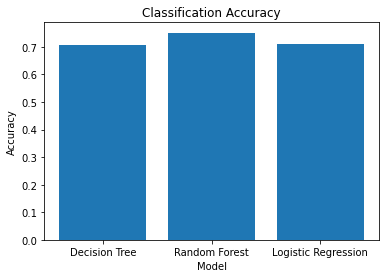

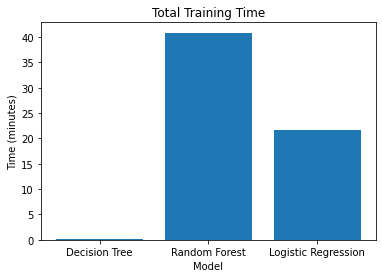

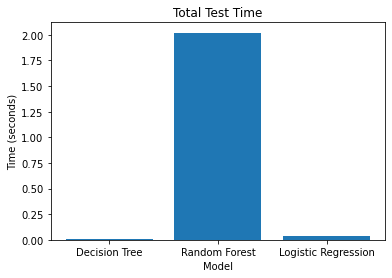

In [28]:
# Classification accuracy bar graph
labels = ['Decision Tree', 'Random Forest', 'Logistic Regression']

accuracy = [dt_max_accuracy, rf_max_accuracy, lr_max_accuracy]
plt.bar(labels, accuracy)
plt.title('Classification Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# Total training time bar graph
training_time = [dt_total_train_time, rf_total_train_time, lr_total_train_time]
plt.bar(labels, training_time)
plt.title('Total Training Time')
plt.xlabel('Model')
plt.ylabel('Time (minutes)')
plt.show()

# Total test time bar graph
test_time = [dt_total_test_time, rf_total_test_time, lr_total_test_time]
plt.bar(labels, test_time)
plt.title('Total Test Time')
plt.xlabel('Model')
plt.ylabel('Time (seconds)')
plt.show()
